In [4]:
import gym_super_mario_bros
import gymnasium as gym
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT, SIMPLE_MOVEMENT
from nes_py.wrappers import JoypadSpace

env = gym_super_mario_bros.make("SuperMarioBros-v3")
env = JoypadSpace(env, COMPLEX_MOVEMENT)

In [5]:
COMPLEX_MOVEMENT, SIMPLE_MOVEMENT

([['NOOP'],
  ['right'],
  ['right', 'A'],
  ['right', 'B'],
  ['right', 'A', 'B'],
  ['A'],
  ['left'],
  ['left', 'A'],
  ['left', 'B'],
  ['left', 'A', 'B'],
  ['down'],
  ['up']],
 [['NOOP'],
  ['right'],
  ['right', 'A'],
  ['right', 'B'],
  ['right', 'A', 'B'],
  ['A'],
  ['left']])

In [4]:
done = True
for step in range(2500):
    if done:
        state = env.reset()
    # pip install gym==0.23.1
    state, reward, done, info = env.step(env.action_space.sample())
    env.render()
env.close()

2024-02-20 23:12:27.544 Python[56224:5266419] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/7m/74_ct3hx33d878n626w1wxyc0000gn/T/org.python.python.savedState


In [6]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize


def downscale_obs(obs, new_size=(42, 42), to_gray=True):
    if to_gray:
        # To convert to grayscale, we simply take the maximum value
        # across the channel dimension for good constrast.
        return resize(obs, new_size, anti_aliasing=True).max(axis=2)
    return resize(obs, new_size, anti_aliasing=True)

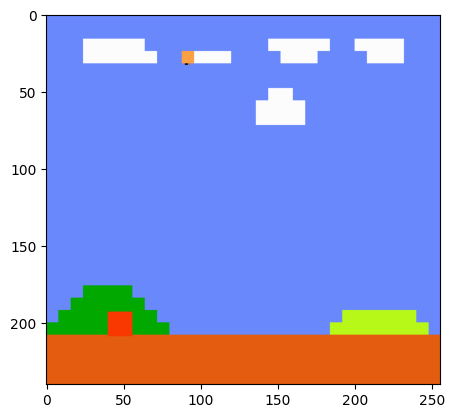

In [7]:
plt.imshow(env.render("rgb_array"))

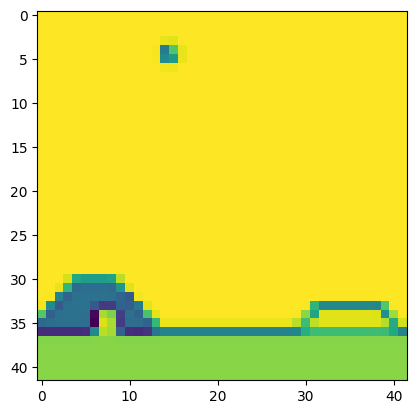

In [8]:
plt.imshow(downscale_obs(env.render("rgb_array")))

In [10]:
from collections import deque

import torch
import torch.nn.functional as F
from torch import nn, optim


def prepare_state(state):
    """downscale state and converts to grayscale, converts to PyTorch tensor, and finally adds a batch dimension"""
    return torch.from_numpy(downscale_obs(state, to_gray=True)).float().unsqueeze(dim=0)


def prepare_multi_state(state1, state2):
    """given an existing 3-frame state1 and a single frame 2, adds the latest frame to the queue"""
    state1 = state1.clone()
    tmp = torch.from_numpy(downscale_obs(state2, to_gray=True)).float()
    state1[0][0] = state1[0][1]
    state1[0][1] = state1[0][2]
    state1[0][2] = tmp
    return state1


def prepare_initial_state(state, N=3):
    """create a state with three copies of the same frame and adds a batch dimension"""
    state_ = torch.from_numpy(downscale_obs(state, to_gray=True)).float()
    tmp = state_.repeat((N, 1, 1))
    return tmp.unsqueeze(dim=0)

In [50]:
def policy(qvalues, eps=None):
    if eps is not None:
        if torch.rand(1) < eps:
            return torch.randint(low=0, high=7, size=(1,))
        return torch.argmax(qvalues)
    return torch.multinomial(F.softmax(F.normalize(qvalues)), num_samples=1)

In [41]:
from random import shuffle

import torch
import torch.nn.functional as F
from torch import nn, optim


class ExperienceReplay:
    def __init__(self, N=500, batch_size=100):
        self.N = N  # A
        self.batch_size = batch_size  # B
        self.memory = []
        self.counter = 0

    def add_memory(self, state1, action, reward, state2):
        self.counter += 1
        if self.counter % 500 == 0:  # C
            self.shuffle_memory()

        if len(self.memory) < self.N:  # D
            self.memory.append((state1, action, reward, state2))
        else:
            rand_index = np.random.randint(0, self.N - 1)
            self.memory[rand_index] = (state1, action, reward, state2)

    def shuffle_memory(self):  # E
        shuffle(self.memory)

    def get_batch(self):  # F
        if len(self.memory) < self.batch_size:
            batch_size = len(self.memory)
        else:
            batch_size = self.batch_size
        if len(self.memory) < 1:
            print("Error: No data in memory.")
            return None
        # G
        ind = np.random.choice(np.arange(len(self.memory)), batch_size, replace=False)
        batch = [self.memory[i] for i in ind]  # batch is a list of tuples
        state1_batch = torch.stack([x[0].squeeze(dim=0) for x in batch], dim=0)
        action_batch = torch.Tensor([x[1] for x in batch]).long()
        reward_batch = torch.Tensor([x[2] for x in batch])
        state2_batch = torch.stack([x[3].squeeze(dim=0) for x in batch], dim=0)
        return state1_batch, action_batch, reward_batch, state2_batch

## ICM Components

In [42]:
class Phi(nn.Module):
    def __init__(self):
        super(Phi, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2, padding=1)

    def forward(self, x):
        x = F.normalize(x)
        y = F.elu(self.conv1(x))
        y = F.elu(self.conv2(y))
        y = F.elu(self.conv3(y))
        y = F.elu(self.conv4(y))  # Size: [1, 32, 3, 3]
        y = y.flatten(start_dim=1)  # Size: N, 288
        return y


class Gnet(nn.Module):
    def __init__(self):
        super(Gnet, self).__init__()
        self.linear1 = nn.Linear(576, 256)
        self.linear2 = nn.Linear(256, 12)

    def forward(self, state1, state2):
        x = torch.cat((state1, state2), dim=1)
        y = F.relu(self.linear1(x))
        y = self.linear2(y)
        y = F.softmax(y, dim=1)
        return y


class Fnet(nn.Module):
    def __init__(self):
        super(Fnet, self).__init__()
        self.linear1 = nn.Linear(300, 256)
        self.linear2 = nn.Linear(256, 288)

    def forward(self, state, action):
        action_ = torch.zeros(action.shape[0], 12)
        indices = torch.stack((torch.arange(action.shape[0]), action.squeeze()), dim=0)
        indices = indices.tolist()
        action_[indices] = 1.0
        x = torch.cat((state, action_), dim=1)
        y = F.relu(self.linear1(x))
        y = self.linear2(y)
        return y

In [43]:
class Qnetwork(nn.Module):
    def __init__(self):
        super(Qnetwork, self).__init__()
        # in_channels, out_channels, kernel_size, stride=1, padding=0
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=32, kernel_size=(3, 3), stride=2, padding=1
        )
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2, padding=1)
        self.linear1 = nn.Linear(288, 100)
        self.linear2 = nn.Linear(100, 12)

    def forward(self, x):
        x = F.normalize(x)
        y = F.elu(self.conv1(x))
        y = F.elu(self.conv2(y))
        y = F.elu(self.conv3(y))
        y = F.elu(self.conv4(y))
        y = y.flatten(start_dim=2)
        y = y.view(y.shape[0], -1, 32)
        y = y.flatten(start_dim=1)
        y = F.elu(self.linear1(y))
        y = self.linear2(y)  # size N, 12
        return y

In [44]:
params = {
    "batch_size": 150,
    "beta": 0.2,
    "lambda": 0.1,
    "eta": 1.0,
    "gamma": 0.2,
    "max_episode_len": 100,
    "min_progress": 15,
    "action_repeats": 6,
    "frames_per_state": 3,
}
replay = ExperienceReplay(N=1000, batch_size=params["batch_size"])
Qmodel = Qnetwork()
encoder = Phi()
forward_model = Fnet()
inverse_model = Gnet()
forward_loss = nn.MSELoss(reduction="none")
inverse_loss = nn.CrossEntropyLoss(reduction="none")
qloss = nn.MSELoss()
all_model_params = list(Qmodel.parameters()) + list(encoder.parameters())
all_model_params += list(forward_model.parameters()) + list(inverse_model.parameters())
opt = optim.Adam(lr=0.001, params=all_model_params)

In [45]:
def loss_fn(q_loss, inverse_loss, forward_loss):
    loss_ = (1 - params["beta"]) * inverse_loss
    loss_ += params["beta"] * forward_loss
    loss_ = loss_.sum() / loss_.flatten().shape[0]
    loss = loss_ + params["lambda"] * q_loss
    return loss


def reset_env():
    env.reset()
    state1 = prepare_initial_state(env.render("rgb_array"))
    return state1

In [46]:
def ICM(state1, action, state2, forward_scale=1.0, inverse_scale=1e4):
    state1_hat = encoder(state1)
    state2_hat = encoder(state2)
    state2_hat_pred = forward_model(state1_hat.detach(), action.detach())
    forward_pred_err = forward_scale * forward_loss(
        state2_hat_pred, state2_hat.detach()
    ).sum(dim=1).unsqueeze(dim=1)
    pred_action = inverse_model(state1_hat, state2_hat)
    inverse_pred_err = inverse_scale * inverse_loss(
        pred_action, action.detach().flatten()
    ).unsqueeze(dim=1)
    return forward_pred_err, inverse_pred_err

In [47]:
def minibatch_train(use_explicit=True):
    state1_batch, action_batch, reward_batch, state2_batch = replay.get_batch()
    action_batch = action_batch.view(action_batch.shape[0], 1)
    reward_batch = reward_batch.view(reward_batch.shape[0], 1)
    forward_pred_err, inverse_pred_err = ICM(state1_batch, action_batch, state2_batch)
    i_reward = (1.0 / params["eta"]) * forward_pred_err
    reward = i_reward.detach()
    if use_explicit:
        reward += reward_batch

    qvals = Qmodel(state2_batch)
    reward += params["gamma"] * torch.max(qvals)
    reward_pred = Qmodel(state1_batch)
    reward_target = reward_pred.clone()
    indices = torch.stack(
        (torch.arange(action_batch.shape[0]), action_batch.squeeze()), dim=0
    )
    indices = indices.tolist()
    reward_target[indices] = reward.squeeze()
    q_loss = 1e5 * qloss(F.normalize(reward_pred), F.normalize(reward_target.detach()))
    return forward_pred_err, inverse_pred_err, q_loss

In [62]:
from tqdm.autonotebook import tqdm

epochs = 1000
env.reset()
state1 = prepare_initial_state(env.render("rgb_array"))
eps = 0.15
losses = []
episode_length = 0
switch_to_eps_greedy = 1000
state_deque = deque(maxlen=params["frames_per_state"])
e_reward = 0.0
last_x_pos = env.env.env.env._x_position
ep_lengths = []
use_explicit = False
for i in tqdm(range(epochs)):
    opt.zero_grad()
    episode_length += 1
    q_val_pred = Qmodel(state1)
    if i > switch_to_eps_greedy:
        action = int(policy(q_val_pred, eps))
    else:
        action = int(policy(q_val_pred))
    for j in range(params["action_repeats"]):
        state2, e_reward_, done, info = env.step(action)
        last_x_pos = info["x_pos"]
        if done:
            state1 = reset_env()
            break
        e_reward += e_reward_
        state_deque.append(prepare_state(state2))
    state2 = torch.stack(list(state_deque), dim=1)
    replay.add_memory(state1, action, e_reward, state2)
    e_reward = 0
    if episode_length > params["max_episode_len"]:
        if info["x_pos"] - last_x_pos < params["min_progress"]:
            done = True
        else:
            last_x_pos = info["x_pos"]
    if done:
        ep_lengths.append(info["x_pos"])
        state1 = reset_env()
        last_x_pos = env.env.env.env._x_position
        episode_length = 0
    else:
        state1 = state2

    if len(replay.memory) < params["batch_size"]:
        continue
    forward_pred_err, inverse_pred_err, q_loss = minibatch_train(use_explicit=False)
    loss = loss_fn(q_loss, forward_pred_err, inverse_pred_err)
    loss_list = (
        q_loss.mean(),
        forward_pred_err.flatten().mean(),
        inverse_pred_err.flatten().mean(),
    )
    losses.append(loss_list)
    loss.backward()
    opt.step()

/var/folders/7m/74_ct3hx33d878n626w1wxyc0000gn/T/ipykernel_58357/3259297072.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
  0%|                                                                                                                         | 0/1000 [00:00<?, ?it/s]/var/folders/7m/74_ct3hx33d878n626w1wxyc0000gn/T/ipykernel_58357/4178195245.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.multinomial(F.softmax(F.normalize(qvalues)), num_samples=1)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:07<00:00,  1.83it/s]


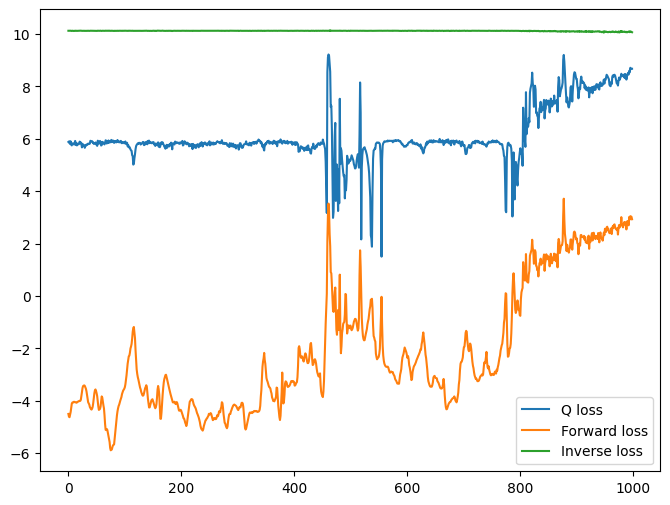

In [63]:
losses_ = np.array([[l.detach().numpy() for l in loss] for loss in losses])
plt.figure(figsize=(8, 6))
plt.plot(np.log(losses_[:, 0]), label="Q loss")
plt.plot(np.log(losses_[:, 1]), label="Forward loss")
plt.plot(np.log(losses_[:, 2]), label="Inverse loss")
plt.legend()
plt.show()